In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed
import json,itertools

In [2]:
## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
#rle转为mask
def rle_decode(RLE, width, height):
    
    #转化string为array 
    inputs = RLE.split()
    array = np.fromiter(inputs, dtype = np.uint)
    
    #转化array形状为(2, N)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    #RLE解码
    head ,length = array
    mask = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(head, length)])

    #建立the binary mask,后续接入pycocotools
    imagemsk = np.zeros(width * height, dtype = np.uint8)
    imagemsk[mask] = 1
    imagemsk = imagemsk.reshape((height, width))
    imagemsk = np.asfortranarray(imagemsk) 
    
    return imagemsk

In [3]:
#将the binary mask转化为uncomposed rle
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [4]:
## Based on:https://www.kaggle.com/coldfir3/efficient-coco-dataset-generator?scriptVersionId=79100851
def annotate(idx, row, cat_ids):
        # Binary mask
        mask = rle_decode(row['annotation'], row['width'], row['height']) 
        
        # 使用coco重编码mask为RLE
        coco_rle = maskUtils.encode(mask) 
        
        # 格式变为utf-8
        coco_rle['counts'] = coco_rle['counts'].decode('utf-8') 
        
        # 计算mask面积
        coco_area = maskUtils.area(coco_rle).item() 
        
        # 计算mask bbox
        coco_bbox = maskUtils.toBbox(coco_rle).astype(int).tolist()

        #为采用uncomposed rle，还是用自己的binary_mask_to_rle 
        enc = binary_mask_to_rle(mask)
        
        #汇入annotation
        annotation = {
            'segmentation': enc,
            'bbox': coco_bbox,
            'area': coco_area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':1,  #using compressed RLE
            'id':idx
        }
        return annotation

In [5]:
#coco json文件生成
def coco_structure(transfile, workers = 4):
    
    ## 创建文件开头
    cat_ids = {name:id+1 for id, name in enumerate(transfile.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in transfile.groupby('id').agg('first').iterrows()]
    
    ## 创建annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(transfile.iterrows(), total = len(transfile)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

In [6]:
#比赛给出的train.csv
transfile = pd.read_csv('E:/Desktop/Final/sartorius-cell-instance-segmentation/train.csv')
root = coco_structure(transfile)
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

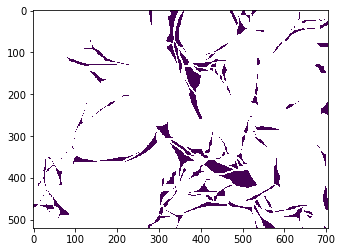

In [7]:
imr = '0a6ecc5fe78a'
i = 0
for ids,row in transfile.iterrows():
    if row.id ==imr:
        rle = transfile.loc[row.name, 'annotation']
        dec = rle_decode(rle, 704, 520)
        plt.imshow(np.ma.masked_where(dec==0, dec))

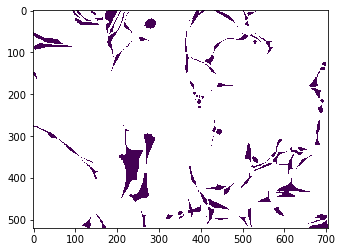

In [8]:
imr = '0c90b86742b2'
i = 0
for ids,row in transfile.iterrows():
    if row.id ==imr:
        rle = transfile.loc[row.name, 'annotation']
        dec = rle_decode(rle, 704, 520)
        plt.imshow(np.ma.masked_where(dec==0, dec))

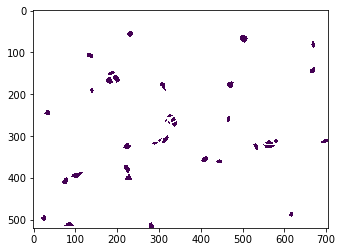

In [9]:
imr = '0ea6df67cc77'
i = 0
for ids,row in transfile.iterrows():
    if row.id ==imr:
        rle = transfile.loc[row.name, 'annotation']
        dec = rle_decode(rle, 704, 520)
        plt.imshow(np.ma.masked_where(dec==0, dec))

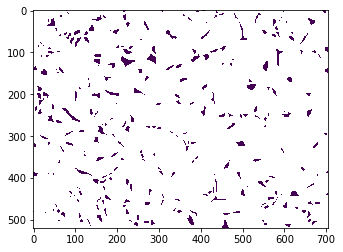

In [10]:
imr = 'e4632744011e'
i = 0
for ids,row in transfile.iterrows():
    if row.id ==imr:
        rle = transfile.loc[row.name, 'annotation']
        dec = rle_decode(rle, 704, 520)
        plt.imshow(np.ma.masked_where(dec==0, dec))